In [397]:
! pip3 install --upgrade emcee corner pytorch-lightning tqdm scipy zuko pandas

  Using cached pandas-2.2.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.2-cp312-cp312-macosx_11_0_arm64.whl (11.3 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner
import zuko
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f'Using device: {device}')

Using device: cuda


In [5]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f'CUDA available: {cuda_available}')

# Determine the device to use
device = torch.device("cuda" if cuda_available else "cpu")
print(f'Using device: {device}')

# If CUDA is available, print the GPU name and other details
if cuda_available:
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'CUDA Capability: {torch.cuda.get_device_capability(0)}')
    print(f'CUDA Version: {torch.version.cuda}')
    print(f'Current CUDA device index: {torch.cuda.current_device()}')
    print(f'Number of available GPUs: {torch.cuda.device_count()}')
    print(f'Device Memory Allocated: {torch.cuda.memory_allocated(0)} bytes')
    print(f'Device Memory Cached: {torch.cuda.memory_reserved(0)} bytes')

CUDA available: True
Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Capability: (8, 6)
CUDA Version: 12.4
Current CUDA device index: 0
Number of available GPUs: 1
Device Memory Allocated: 0 bytes
Device Memory Cached: 0 bytes


In [8]:
!nvidia-smi


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# Create a random tensor on the GPU
tensor = torch.rand(3, 3, device=device)
print(f'Tensor on {device}:')
print(tensor)

# Check memory allocated after creating the tensor
print(f'Device Memory Allocated: {torch.cuda.memory_allocated(0)} bytes')
print(f'Device Memory Cached: {torch.cuda.memory_reserved(0)} bytes')

Tensor on cuda:
tensor([[0.6515, 0.2693, 0.8771],
        [0.7860, 0.2505, 0.1527],
        [0.9172, 0.0773, 0.0069]], device='cuda:0')
Device Memory Allocated: 512 bytes
Device Memory Cached: 2097152 bytes


# Simulation-based (likelihood-free) inference
Originally by **Siddharth Mishra-Sharma**.
Updated by **Jessie Micallef** ([jessiem@mit.edu](mailto:jessiem@mit.edu))

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jessimic//sbi-tutorial-iaifi/blob/main/Tutorial1_Basic_NRE_NPE.ipynb)

## 1. Introduction

Simulation-based inference (SBI) is a powerful class of methods for performing inference in settings where the likelihood is computationally intractible or challenging, but simulations can be realized via forward modeling. This tutorial focuses on an introduction to implicit likelihood and building up two common modern _neural_ SBI techniques.

In this lecture we will
1. Introduce the concept of an [implicit likelihood](#implicit_llh), how to use it perform inference, and approxiate posterior with MCMC;
2. Apply [example](#nre) using neural likelihood-ratio estimation (NRE)
3. Apply [example](#npe) using neural posterior estimation (NPE);

As examples, we will look at a simple Gaussian-signal-on-power-law-background ("bump hunt"), where the likelihood is tractable, and a more complicated example of inferring a distribution of point sources, where the likelihood is computationally difficult. We will emphasize what it means for a likelihood to be computationally challenging and where the advantages of SBI come in.

<img src=./assets/likelihood.png alt= “” width=800>
<img src=./assets/sbi.png alt= “” width=800>


# 1.1 Simple bump-on-power-law example

As an initial example, we'll look at a singal and background example. Consider a Gaussian signal ($x_s$), which we can parameterized by some [amplitude ($A_s$), mean location ($\mu_s$), standard deviation ($\sigma_s$)]. This signal will be on top of the background ($x_b$), represented by a power law parameterized as [amplitude ($A_b$), power-law exponent ($n_b$)].
$$x_s = A_s\,\exp^{-(y - \mu_s)^2 / 2\sigma_s^2}$$
$$ x_b = A_b\,y^{n_b}$$
$$x \sim \mathrm{Pois}(x_b + x_s)$$

Let's reproduce one of the most popular examples in particle physics, the mass plot for the higgs boson:

<img src=./assets/higgs_mass_plot_cms.jpg alt= “” width=700>

With some choice parameters of the power-law background and Guassian signal, we can get something that resembles the above plot:
<a id="parameters"></a>

Text(0.5, 1.0, 'Higgs boson decaying into a pair of photons')

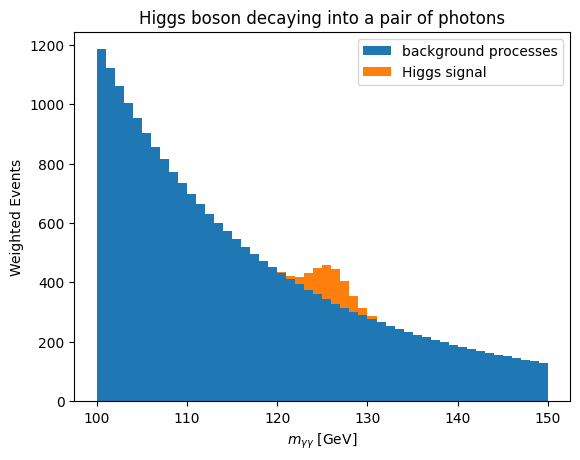

In [3]:
mass_sample = np.linspace(100, 150, 100)  # Mass range in GeV

# Power-law background
exp_back = -5.5
amp_back = 6e13
y_b_sample = amp_back * (mass_sample ** exp_back)  

# Gaussian signal 
amp_signal=60
mu_signal=126 #Measured higgs mass
std_signal = 2
y_s_sample =  amp_signal * np.exp(-((mass_sample - mu_signal) ** 2) / (2 * std_signal ** 2)) 

#Make stacked histogram to see distribution that you would be pulling from
plt.hist([mass_sample, mass_sample], bins=50, weights=[y_b_sample, y_s_sample], label=['background processes', 'Higgs signal'], stacked=True)

plt.legend()
plt.xlabel(r'$m_{\gamma \gamma}$ [GeV]')
plt.ylabel("Weighted Events")
plt.title("Higgs boson decaying into a pair of photons")


### Now we've visualized this, we will make a single forward model that contains both signal + background

In [9]:
#Make signal + background into one "forward model"
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top 
    of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal
    #print(amp_b , exp_b, amp_s, mu_s, std_s)
    x = x_b + x_s  # Total mean signal

    return x

def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

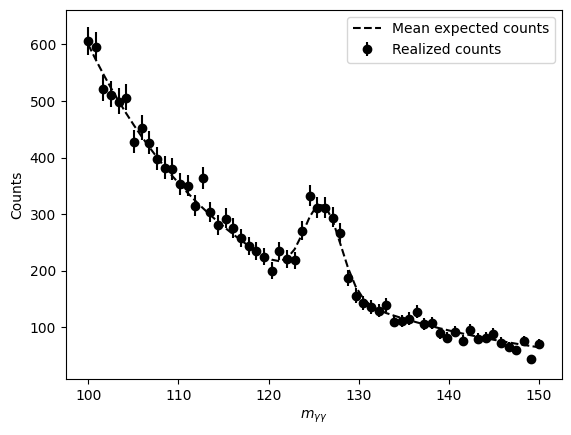

In [10]:
y = np.linspace(100, 150, 60)  # Dependent variable
amp_signal= 150 #BUMP UP amplitute for ease

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=amp_signal, mu_s=mu_signal, std_s=std_signal,  # Signal params -- BUMP UP amplitute and std for ease
                    amp_b=amp_back, exp_b=exp_back)  # Background params
# Realized counts
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel(r"$m_{\gamma\gamma}$")
plt.ylabel("Counts")

plt.legend();

## 1.2 The explicit likelihood

In this case, we can write down a log-likelihood as a Poisson over the mean returned by the forward model.

In [11]:
def log_like(theta, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) 
    on top of a power-law background (amp_b, exp_b).
    """
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

Let's focus on just 2 parameters for simplicity, the signal amplitude and mean location. The likelihood in this case is:

In [12]:
def log_like_sig(params, y, x, set_amp_back=6e7,set_std_signal=2,set_exp_back=-5.5):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = params
    std_s, amp_b, exp_b = set_std_signal, set_amp_back, set_exp_back
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like_sig([amp_signal, mu_signal], y, x, set_amp_back=amp_back, set_std_signal=std_signal,set_exp_back=exp_back)

-242.56957167149608

### Get a maximum-liklelihood estimate:

In [13]:
# Initial guess for the parameters
initial_guess = [90., 135.] #amp_s_guess, mu_s_guess

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (100, 150))} #Set bounds (amp_s_min, amp_s_max) and (mu_s_min, mu_s_max)

# Perform the optimization using basinhopping
opt = basinhopping(lambda thetas: -log_like_sig(thetas, y, x,set_amp_back=amp_back,set_std_signal=std_signal,set_exp_back=exp_back),
                   initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (amp_signal, mu_signal)))


MLE parameters: [  2.04159517 100.        ]; true parameters: (150, 126)


### And approximate posterior using `emcee`:

In [15]:
def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 100 < mu_s < 150: #Set bounds amp_s and mu_s
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x, set_amp_back=amp_back,set_std_signal=std_signal,set_exp_back=exp_back)
    

In [16]:
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-1 * np.random.randn(nwalkers, ndim) #starting position for the walkers with slight variation
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:29<00:00, 167.92it/s]


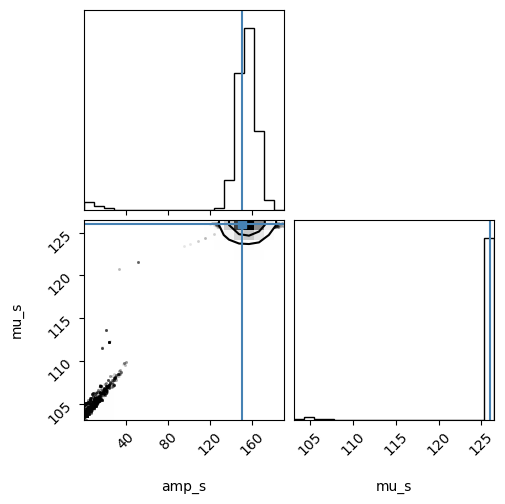

In [17]:
# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True) #"Burn in" or discrading the first X steps is common practice for MCMC
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[150, 126], smooth=1.);

### **Exercise**: How does this change if you alter the number of walkers, sampling, burn-in, etc.? 

### **Bonus Exercise**: What if you use another MC sampling method (https://chi-feng.github.io/mcmc-demo/)?

Hint: You will need to use a differnt package instead of emcee. Some options: pyro, pymc, pyhmc

In [ ]:
#Try replacing MCMC with pyro HMC

## 1.3 The implicit likelihood
<a id="implicit_llh"></a>

Now we will do inference without relying on the explicit likelihood evaluation. The key realization is that samples from the forward model implicitly encode the likelihood; when we are simulating data points $x$ for different parameter points $\theta$, we are drawing samples from the likelihood:
$$x\sim p(x\mid\theta)$$
which is where the _implicit_ aspect comes from. Let's write down a bump simulator:

#### Let's write a simulator for the bump example:
<a id="bump_sim"></a>

In [17]:
def bump_simulator(thetas, y,set_amp_back=6e13,set_std_signal=2,set_exp_back=-5.5):
    """ Simulate samples from the bump forward model given theta = (amp_s, mu_s) and dependent variable points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = set_std_signal, set_amp_back, set_exp_back
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    settings = {"amp_s": amp_s, "mu_s": mu_s, "std_s": std_s, "amp_b": amp_b, "exp_b": exp_b}
    return x, settings

# Test it out
#y = np.linspace(100, 150, 60)

x_simulated, setting_vals = bump_simulator([amp_signal, mu_signal], y, set_amp_back=amp_back,set_std_signal=std_signal,set_exp_back=exp_back)
print(x_simulated)

[606 627 515 523 549 455 503 440 443 423 387 404 345 311 331 359 302 260
 277 260 240 234 251 233 245 216 227 235 270 298 315 323 281 244 178 169
 152 150 132 130 121 128 100 121 103  93 105  94 101  87  91 100  72  87
  70  65  76  71  54  70]


### **Exercise:** Run the bump simulator multiple times. Notice that each time you run the cell above, the distribution changes. Play with the [parameter settings](#implicit_llh) in the signal and background. What makes the signal bump larger? What settings for the background makes your signal disappear? What moves the signal bump?


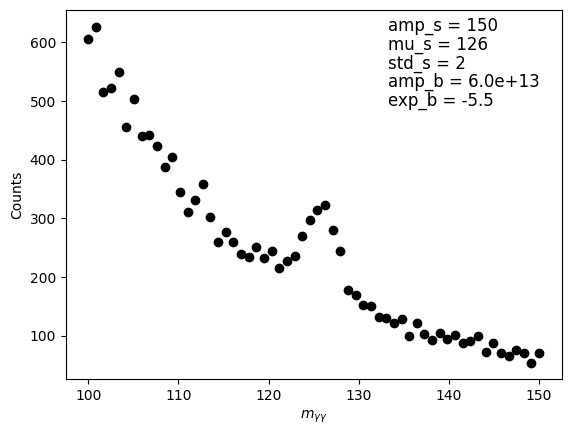

In [18]:
#Plot bump simulator
plt.plot(y,x_simulated,'ko')
plt.xlabel(r"$m_{\gamma\gamma}$")
plt.ylabel("Counts")
for i, (name, value) in enumerate(setting_vals.items()):
    if value > 200:
            plt.text(0.65, 0.98 - i * 0.05, f"{name} = {value:.1e}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    else:
        plt.text(0.65, 0.98 - i * 0.05, f"{name} = {value}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

## 1.4 Approximate Bayesian Computation (ABC)

We will not be focusing on ABC, but the concept can help to understand as a stepping stone before we start to use neural methods in place of Bayesian Computation. Brief overview:

<img src=./assets/abc_carol.png alt= “” width=800>


The idea behind ABC is to simulate samples from the forward model (with the parameters $\theta$ drawn from a prior) and compare it to the dataset of interest $x$. If the data and realized samples are close enough to each other according to some criterion (such as Mean Squared Error), we keep the parameter points.

Downsides of vanilla ABC:
- How to summarize the data? Curse of dimensionality / loss of information.
- How to compare with data? Likelihood may not be available.
- Choice of acceptance threshold: Precision/efficiency tradeoff.
- Need to re-run pipeline for new data or new prior.

## 1.5 Using Neural estimation methods 

Depending on your situation, different neural estimation may be useful in certain cases. From Carol's lecture, here is a summary of the features of Neural likelihood-Ratio Estimation ([NRE](#nre)), Neural Posterior Estimation ([NPE](#npe)), and Neural Likelihood Estimation (NLE). 

<img src=./assets/neural_estimation.png alt= “” width=800>


# 2. Neural likelihood-ratio estimation (NRE)
<a id="nre"></a>

Now we will still be using the [bump simulator](#bump_sim) (Section 1.3), but now feed this into a neural network and explore how to use NRE to evaluate the likelihood ratio.

<img src=./assets/nre.png alt= “” width=1000>

For numerical stability, the alternate hypothesis $\theta_0$ can be assumed to be one where $x$ and $\theta$ are not correlated, i.e., drawn from the individual marginal distributions $\{x, \theta\} \sim p(x)\,p(\theta)$. Then the alternate has support over the entire parameter space, instead of being a single hypothesis $\theta_0$.

In this case, we get the likelihood-to-evidence ratio,

$$\hat r(x, \theta) = \frac{s(x, \theta)}{1 - s(x, \theta)} = \frac{p(x,\theta)}{p(x)p(\theta)} = \frac{p(x\mid\theta)}{p(x)}$$

$\hat r(x, \theta)$ can be shown to be the classifier logit, i.e. the output before softmaxxing into the decision function with range between 0 and 1.

#### Start by creating some training data with [bump simulator](#bump_sim). **FILL IN CODE**

In [19]:
n_train = 50_000

# Simulate training data

########## ADD CODE HERE ##########
##### Use a uniform random distribution to create a theta samples in some range around your amp_s and mu_s true values
##### For each theta sample, use the bump simulator. You will also need to give the simulator the y linspace sampling of the mass (mu_s) space
########## ADD CODE HERE ##########

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

100%|██████████| 50000/50000 [00:00<00:00, 64600.42it/s]


## 2.1. As our parameterized classifier, we will use a simple MLP or dense network
<a id="mlp"></a>

In [20]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

Create a neural ratio estimator class, with a corresponding loss function. The loss is a simple [binary cross-entropy loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) that discriminates between samples from the joint distribution $\{x, \theta\} \sim p(x\mid\theta)$ and those from a product of marginals $\{x, \theta\} \sim p(x)\,p(\theta)$. Samples from the latter are obtained by shuffling joint samples from within a batch.

The binary cross-entropy loss is used as the classifier loss to distinguish samples from the joint and marginals,
$$\mathcal L = - \sum_i y_i \log(p_i)$$
where $y_i$ are the true labels and $p_i$ the softmaxxed probabilities.

### Neural Ration Estimator is defined below. **FILL IN CODE**

In [21]:
class NeuralRatioEstimator(pl.LightningModule):
    """ Simple neural likelihood-to-evidence ratio estimator, using an MLP as a parameterized classifier.
    """
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, theta):

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        #### ADD CODE HERE####
        return ### RETURN LOSS FUNCTION ####
        #### ADD CODE HERE####

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss,on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss,on_step=False, on_epoch=True, prog_bar=True)
        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

### **Bonus Exercise**: Try using another classification loss function. How does this change the outcome?

In [22]:
# Evaluate loss; initially it should be around -log(0.5) = 0.693
nre = NeuralRatioEstimator(x_dim=len(y), theta_dim=2)
nre.loss(x_samples[:64], theta_samples[:64])

tensor([0.7051, 0.6812, 0.7045, 0.6821, 0.7051, 0.6808, 0.7050, 0.6815, 0.7035,
        0.6829, 0.7034, 0.6828, 0.7040, 0.6821, 0.7056, 0.6811, 0.7043, 0.6821,
        0.7056, 0.6808, 0.7043, 0.6821, 0.7040, 0.6824, 0.7050, 0.6817, 0.7042,
        0.6822, 0.7044, 0.6819, 0.7042, 0.6822, 0.7041, 0.6824, 0.7065, 0.6802,
        0.7039, 0.6825, 0.7044, 0.6817, 0.7046, 0.6817, 0.7048, 0.6814, 0.7043,
        0.6826, 0.7035, 0.6829, 0.7042, 0.6822, 0.7034, 0.6831, 0.7054, 0.6814,
        0.7040, 0.6825, 0.7041, 0.6824, 0.7040, 0.6820, 0.7048, 0.6816, 0.7049,
        0.6815, 0.7033, 0.6835, 0.7051, 0.6812, 0.7040, 0.6823, 0.7044, 0.6821,
        0.7061, 0.6804, 0.7043, 0.6821, 0.7035, 0.6827, 0.7045, 0.6817, 0.7053,
        0.6812, 0.7040, 0.6822, 0.7040, 0.6822, 0.7043, 0.6821, 0.7045, 0.6819,
        0.7043, 0.6820, 0.7034, 0.6831, 0.7035, 0.6827, 0.7040, 0.6821, 0.7035,
        0.6829, 0.7036, 0.6828, 0.7034, 0.6825, 0.7037, 0.6828, 0.7042, 0.6822,
        0.7041, 0.6827, 0.7048, 0.6819, 

In [23]:
#Run dataloader
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [45]:
#Train
trainer = pl.Trainer(max_epochs=20,logger=True)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);
######### Locally took about 3 min on Apple M1 GPU ##########

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 74.2 K | train
--------------------------------------------------
74.2 K    Trainable params
0         Non-trainable params
74.2 K    Total params
0.297     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 352/352 [00:09<00:00, 39.08it/s, v_num=21, val_loss=0.0846, train_loss=0.0824]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 352/352 [00:09<00:00, 39.02it/s, v_num=21, val_loss=0.0846, train_loss=0.0824]


### **Exercise**: Plot the Training and Validation Loss

In [ ]:

# Specify the path to the log directory
log_dir = trainer.logger.log_dir

# Initialize the event accumulator
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Get the scalar values
train_loss = event_acc.Scalars('train_loss')
val_loss = event_acc.Scalars('val_loss')

# Extract the values and steps
train_loss_values = [x.value for x in train_loss]
train_steps = [x.step for x in train_loss]
##### ADD CODE HERE ########
## Pull the validation loss and steps #######
##### ADD CODE HERE ########

plt.figure(figsize=(10, 5))
##### ADD CODE HERE ########
## Plot training loss vs validation loss
##### ADD CODE HERE ########
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss At Each Epoch')
plt.show()

The classifier logits are now an estimator for the likelihood ratio.
#### We can write down a log-likelihood function and use it to sample from the corresponding posterior distribution, just like before. **FILL IN CODE**

In [42]:
def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """
        
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze()

##### ADD CODE HERE ########
theta_test = ## Create oen set of theta (amp_s, mu_s) test points (hint, they must be tuple in np array)
x_test = ## Run bump simulator on test points, over y linspace of mass samples. Hint: Take 0th output of simulator to just get reults and not settings list
##### ADD CODE HERE ########

log_like(theta_test, x_test)

tensor(4.8026, grad_fn=<SqueezeBackward0>)

In [27]:
def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x).detach().numpy()

#### Sample with `emcee`:

In [43]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-1 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:15<00:00, 326.16it/s]


#### Plot approximate posterior:

In [ ]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 119]);

### **Bonus Exercise**: What if you changed the [MLP](#mlp) to a different network architecture? How does this affect your results?

# 3. Neural posterior estimation (NPE)
<a id="npe"></a>

<img src=./assets/npe.png alt= “” width=800>

Construct a neural posterior estimator. It uses a normalizing flow as a (conditional) posterior density estimator, and a feature-extraction network that aligns the directions of variations in parameters $\theta$ and data $x$.
$$  \mathcal L = -\log p_\phi(\theta\mid s_\varphi(x))$$
where $\{\phi, \varphi\}$ are the parameters of the normalizing flow and featurizer MLP, respectively.

### 3.1 Use zuko's Masked Autoregressive Flow

In [30]:
# MAP with 2 sample features and 16 context features, 
flow = zuko.flows.MAF(features=2,context=16,transforms=4, hidden_features=[32,32])

context=torch.randn(2, 16)
samples = flow(context).sample((100,))
flow(context).log_prob(samples)
print(samples.shape)

torch.Size([100, 2, 2])


### 3.2 Create NPE and call flow for the loss

In [31]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, flow):
        super().__init__()
        self.featurizer = featurizer
        self.flow = flow

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow(context).log_prob(theta)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss,on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss,on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

### 3.3 Instantiate the NPE class and look at the loss:

In [ ]:
npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=x_samples.shape[-1], hidden_dim=128, output_dim=16, layers=4),flow=flow)
npe.loss(x_samples[:64], theta_samples[:64])

Train using the same data as before:

In [ ]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);
####### This step took me ~6 min locally on Apple M1 GPU #########

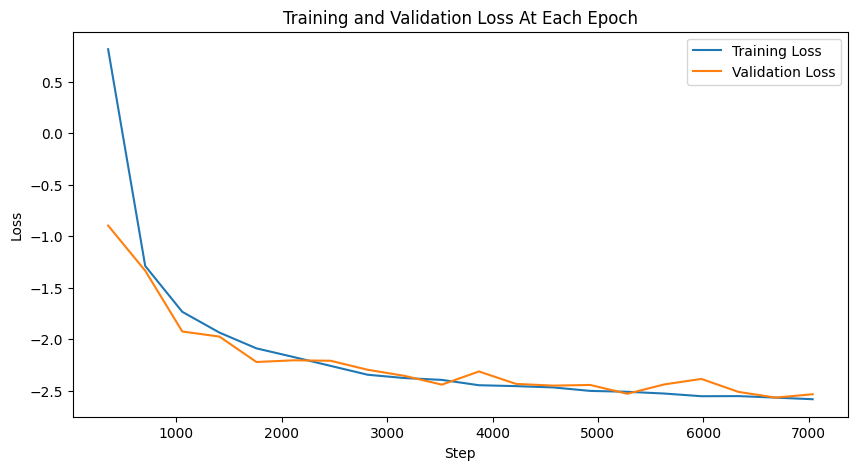

In [34]:
# Specify the path to the log directory
log_dir = trainer.logger.log_dir

# Initialize the event accumulator
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Get the scalar values
train_loss = event_acc.Scalars('train_loss')
val_loss = event_acc.Scalars('val_loss')

# Extract the values and steps
train_loss_values = [x.value for x in train_loss]
train_steps = [x.step for x in train_loss]
##### ADD CODE HERE ########
## Pull the validation loss and steps #######
##### ADD CODE HERE ########

plt.figure(figsize=(10, 5))
##### ADD CODE HERE ########
## Plot training loss vs validation loss
##### ADD CODE HERE ########
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss At Each Epoch')
plt.show()

 We get posterior samples by drawing from 
$$\theta \sim p_\phi(\theta\mid s_\varphi(x)).$$

In [39]:
##### ADD CODE HERE ########
theta_test = ## Create oen set of theta (amp_s, mu_s) test points (hint, they must be tuple in np array)
x_test = ## Run bump simulator on test points, over y linspace of mass samples. Hint: Take 0th output of simulator to just get reults and not settings list
##### ADD CODE HERE ########

In [36]:
npe = npe.to(device) #May need if you are running locally, to connect GPU/CPU devices

In [40]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

(10000, 2)


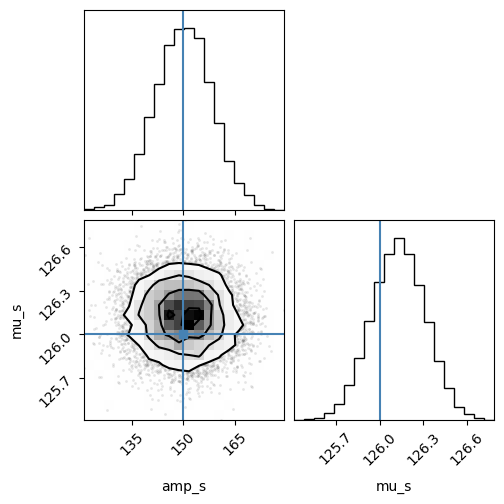

In [41]:
samples_test = npe.flow(context).sample((10000,)) * theta_std + theta_mean
samples_test = samples_test.detach().squeeze().numpy()
print(samples_test.shape)
corner.corner(samples_test, labels=["amp_s", "mu_s"], truths=[150, 126]);

# Further reading

- [The frontier of simulation-based inference](https://arxiv.org/abs/1911.01429) (Cranmer, Brehmer, Louppe): Review paper
- [simulation-based-inference.org](http://simulation-based-inference.org/): List of papers and resources
- [awesome-neural-sbi](https://github.com/smsharma/awesome-neural-sbi): List of papers and resources

<img src=./assets/header.png alt= “” width=800>
Credit: Siddharth